# Active Learning Demo with Cairn.jl

In this notebook, we'll walk through how to perform active learning to fit a polynomial basis expansion model to the Himmelblau potential using the package SteinMD.jl. This notebook is designed to run with Julia 1.8.3.

First, load all necessary packages and plotting scripts:

In [3]:
import Pkg
Pkg.activate("/Users/joannazou/Documents/Github/cesmix-mit/Cairn")
Pkg.resolve()

  Activating project at `~/Documents/Github/cesmix-mit/Cairn`
  No Changes to `~/Documents/Github/cesmix-mit/Cairn/Project.toml`
  No Changes to `~/Documents/Github/cesmix-mit/Cairn/Manifest.toml`


In [6]:
using Cairn
using LinearAlgebra, Random, Statistics, StatsBase, Distributions
using PotentialLearning
using Molly
using ActiveSubspaces
using SpecialPolynomials, SpecialFunctions
using Revise

In [46]:
# plotting scripts - these are kept separate from the package for now
include("/Users/joannazou/Documents/Github/cesmix-mit/Cairn/src/makie/makie.jl")
include("/Users/joannazou/Documents/Github/cesmix-mit/Cairn/examples/misc_utils.jl")


plot_error_metric (generic function with 3 methods)

Now we call on `Himmelblau` as our reference potential:

In [7]:
ref = Himmelblau()

Himmelblau{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(kJ nm⁻¹ mol⁻¹, kJ mol⁻¹)

We observe that at the given temperature, Langevin dynamics fails to converge on the equilibrium probability distribution: 

In [35]:
# temperature of simulation
temp = 300.0u"K"

# define simulator
sim_langevin = OverdampedLangevin(
    dt=0.002u"ps",
    temperature=temp,
    friction=1.0u"ps^-1")

sys0 = init_trajectory(ref, [4.5, -2], logstep=100)
sys = deepcopy(sys0)
@time simulate!(sys, sim_langevin, 1_000_000)

  3.276023 seconds (33.00 M allocations: 1.729 GiB, 20.84% gc time)


System with 1 atoms, boundary RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[Inf nm, Inf nm])

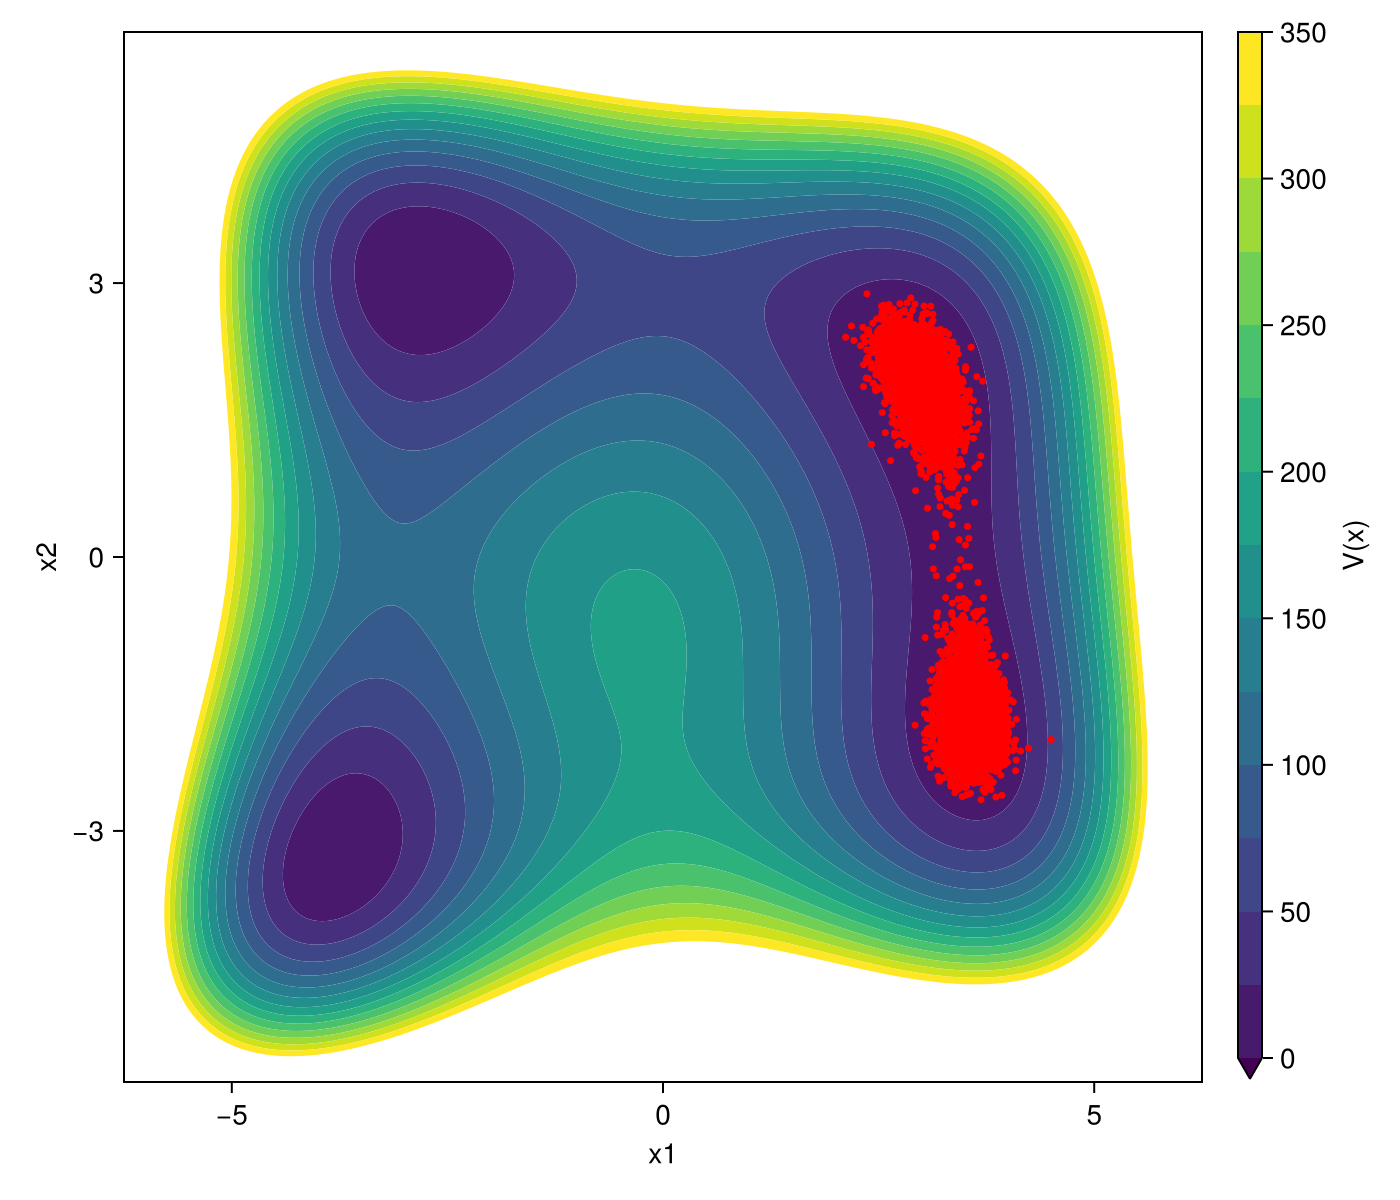

In [36]:
# for plotting
dist_units = u"nm"
xcoord = Vector(limits[1][1]:0.05:limits[1][2]) .* dist_units
ycoord = Vector(limits[2][1]:0.05:limits[2][2]) .* dist_units 
ctr_grid = [xcoord, ycoord]
ctr_lvls = 0:25:350

# plot
f0 = plot_md_trajectory(sys, ctr_grid, fill=true, lvls=ctr_lvls)


## Initial fitting of the machine learning interatomic potential 

In this setting, we develop a *machine learning interatomic potential* (ML-IP) as a data-driven surrogate model of the potential energy function. In particular, we treat the Himmelblau potential as a reference defining the target potential energy surface and fit a *polynomial chaos expansion* (PCE) model to a limited set of training data from the reference. While the Himmelblau potential is available analytically, we use it as a toy example of settings in which evaluating the ground truth requires a computationally intensive calculation. 

We choose the form of our model to be a 2D total-order PCE using Jacobi polynomials up to the 5th order: 

In [16]:
limits = [[-6.25,6.25],[-5.75,5.75]] # boundaries of main support
pce = PolynomialChaos(5, 2, Jacobi{0.5,0.5}, xscl=limits)

PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(5, 2, nothing, Jacobi{0.5, 0.5}, Vector[Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₅(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₁(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₃(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₃(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₁(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₃(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₂(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₂(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x

To begin, we first define a set of evaluation points for validating the fit of our PCE model. In this case, we take a grid of points distributed uniformly over the main support of the potential.

In [17]:
# initialize system properties
atom_mass = 1.0u"g/mol"
boundary = RectangularBoundary(Inf*u"nm")


RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[Inf nm, Inf nm])

In [18]:
# evaluation set: grid over main support
potential(coords) = Cairn.potential_himmelblau(ref, coords)
coords_eval = potential_grid_points(potential, limits, 0.2, cutoff = 400)
sys_eval = define_sys(ref, coords_eval, boundary)

# use grid to define uniform quadrature points
ξ = [ustrip.(Vector(coords)) for coords in coords_eval]
GQint = GaussQuadrature(ξ, ones(length(ξ))./length(ξ))

GaussQuadrature([[-5.85, -4.35], [-5.85, -4.15], [-5.85, -3.95], [-5.85, -3.75], [-5.85, -3.55], [-5.85, -3.35], [-5.65, -4.95], [-5.65, -4.75], [-5.65, -4.55], [-5.65, -4.35]  …  [5.55, -1.75], [5.55, -1.55], [5.55, -1.35], [5.55, -1.15], [5.55, -0.95], [5.55, -0.75], [5.55, -0.55], [5.55, -0.35], [5.55, -0.15], [5.55, 0.05]], [0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476  …  0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476, 0.00037439161362785476])

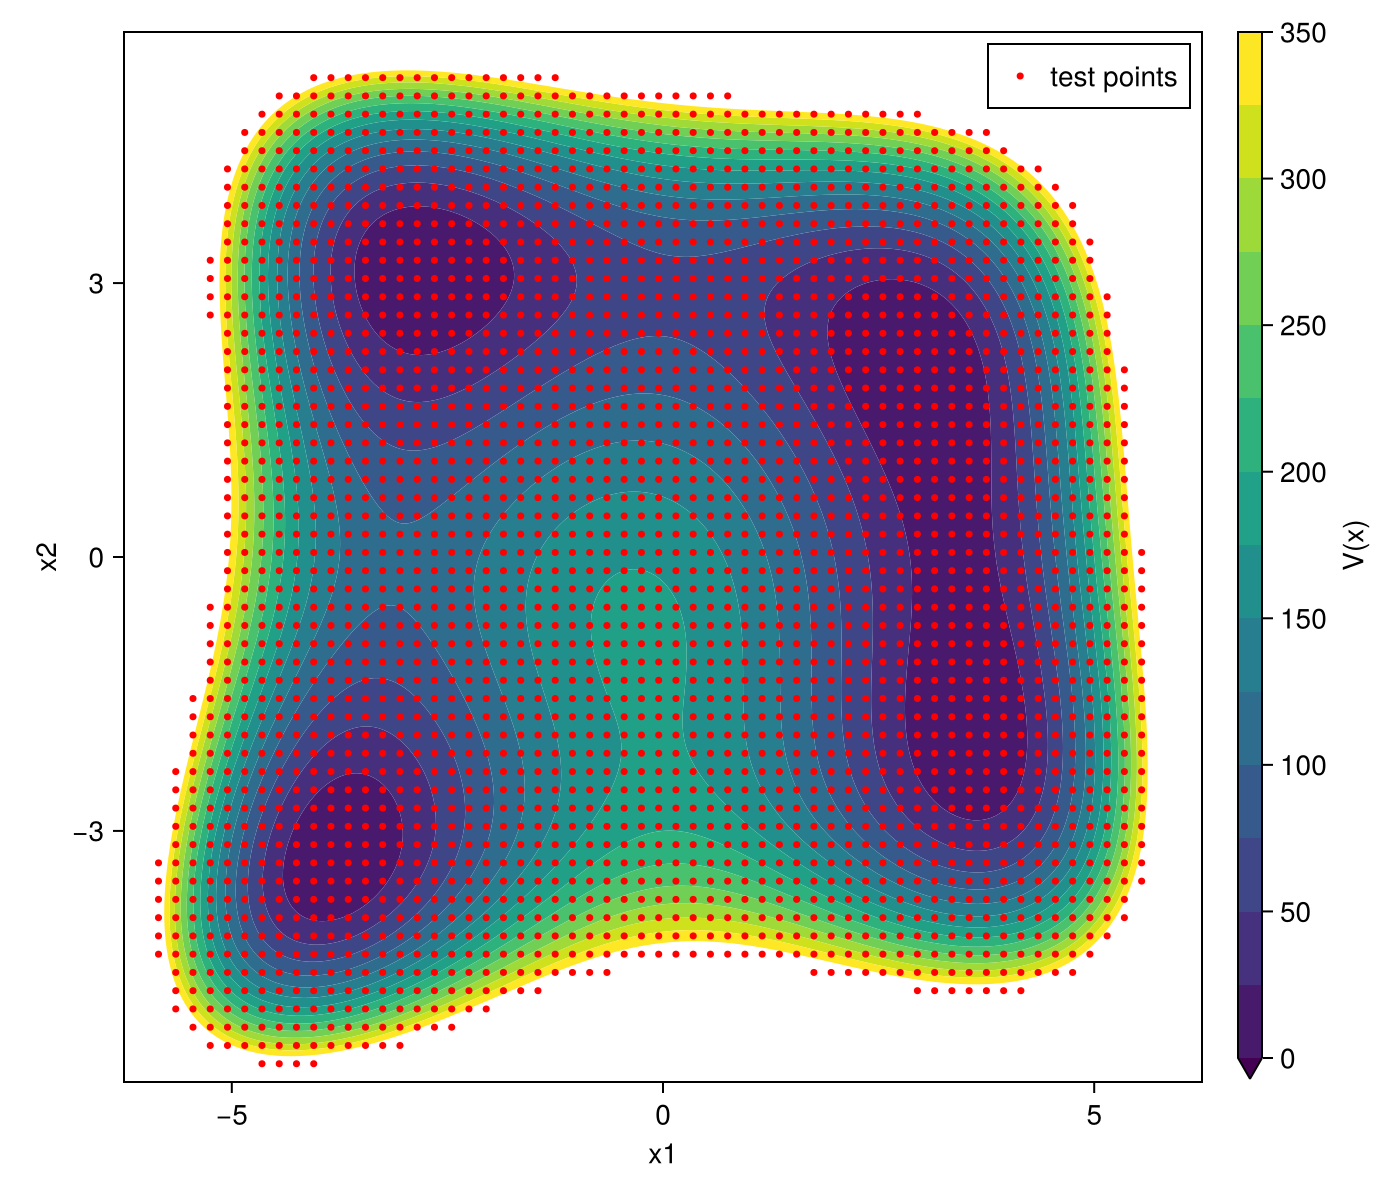

In [19]:
# plot
f0, ax0 = plot_contours_2D(ref, xcoord, ycoord; fill=true, lvls=ctr_lvls)
coordmat = reduce(hcat, get_values(coords_eval))'
scatter!(ax0, coordmat[:,1], coordmat[:,2], color=:red, markersize=5, label="test points")
axislegend(ax0)
f0

The PCE is a linear combination of polynomial basis functions in which the basis coefficients are learned from data. Therefore, to fit our PCE model, we need an initial set of training data. We assume the initial set does not sufficiently sample the probability space, and instead are concentrated within one well of the potential.

Let's define 20 points in one of the wells of the potential energy surface to constitute the initial training set $\mathbf{X}_0 = \{ \mathbf{x}_0^{(i)} \}_{i=1}^J $:

In [57]:
x_train = [[3.8464987622491895, -1.7801390420313014],
[4.096079218176701, -1.9623723102484034],
[3.794900754980532, -2.0790635268608757],
[3.2997659303869744, -2.2798944543828574],
[3.3921279139032157, -2.1410288797166183],
[3.5889845930605545, -2.103609154541564],
[3.367066701220913, -1.3277818179304328],
[3.7936780458955686, -2.457270634134617],
[3.4604931855508254, -1.6495593869168982],
[3.591850102112664, -2.390778252852719],
[3.8764987622491895, -1.8101390420313014],
[4.066079218176701, -1.9323723102484034],
[3.824900754980532, -2.1090635268608757],
[3.2697659303869744, -2.2498944543828574],
[3.4221279139032157, -2.1710288797166183],
[3.5589845930605545, -2.133609154541564],
[3.397066701220913, -1.3577818179304328],
[3.8236780458955686, -2.427270634134617],
[3.4304931855508254, -1.6195593869168982],
[3.561850102112664, -2.420778252852719],
[3.691850102112664, -2.290778252852719]]

coords_train = [SVector(x[1], x[2])u"nm" for x in x_train]
ntrain = length(coords_train)
atoms_train = [Atom(mass=atom_mass, σ=1.0u"nm", ϵ=1.0u"kJ * mol^-1") for i in 1:ntrain]

sys0 = [System(
    atoms=[atoms_i],
    coords=[coords_i],
    boundary=boundary,
    general_inters=(pce,),
    # k = 1.0u"kJ * K^-1 * mol^-1",
) for (atoms_i, coords_i) in zip(atoms_train, coords_train)]

21-element Vector{System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, Tuple{}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, K⁻¹, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², nothing}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Vec

Now we learn the coefficients of the PCE model from the initial training data:

In [58]:
pce0 = deepcopy(pce)
train_potential_e!(sys0, ref, pce0) # wts=[1e4,1])

PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(5, 2, [29.650520811764505, 110.37314299818888, -57.81275366041635, 56.57322163758454, -10.706312723336678, -39.145685383982304, 9.11874068202661, -3.325647984306284, -0.1763337292648177, -12.19278479705572  …  -64.84460692203794, 41.91640164610561, -32.896115144881925, 69.53228881428252, 78.42481739933878, -105.78899379460489, 52.130940080682215, -14.072882525455128, 62.18561841427623, 18.59490251688096], Jacobi{0.5, 0.5}, Vector[Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₅(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₁(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₃(x)), typename

and plot the corresponding contours of the potential energy surface: 

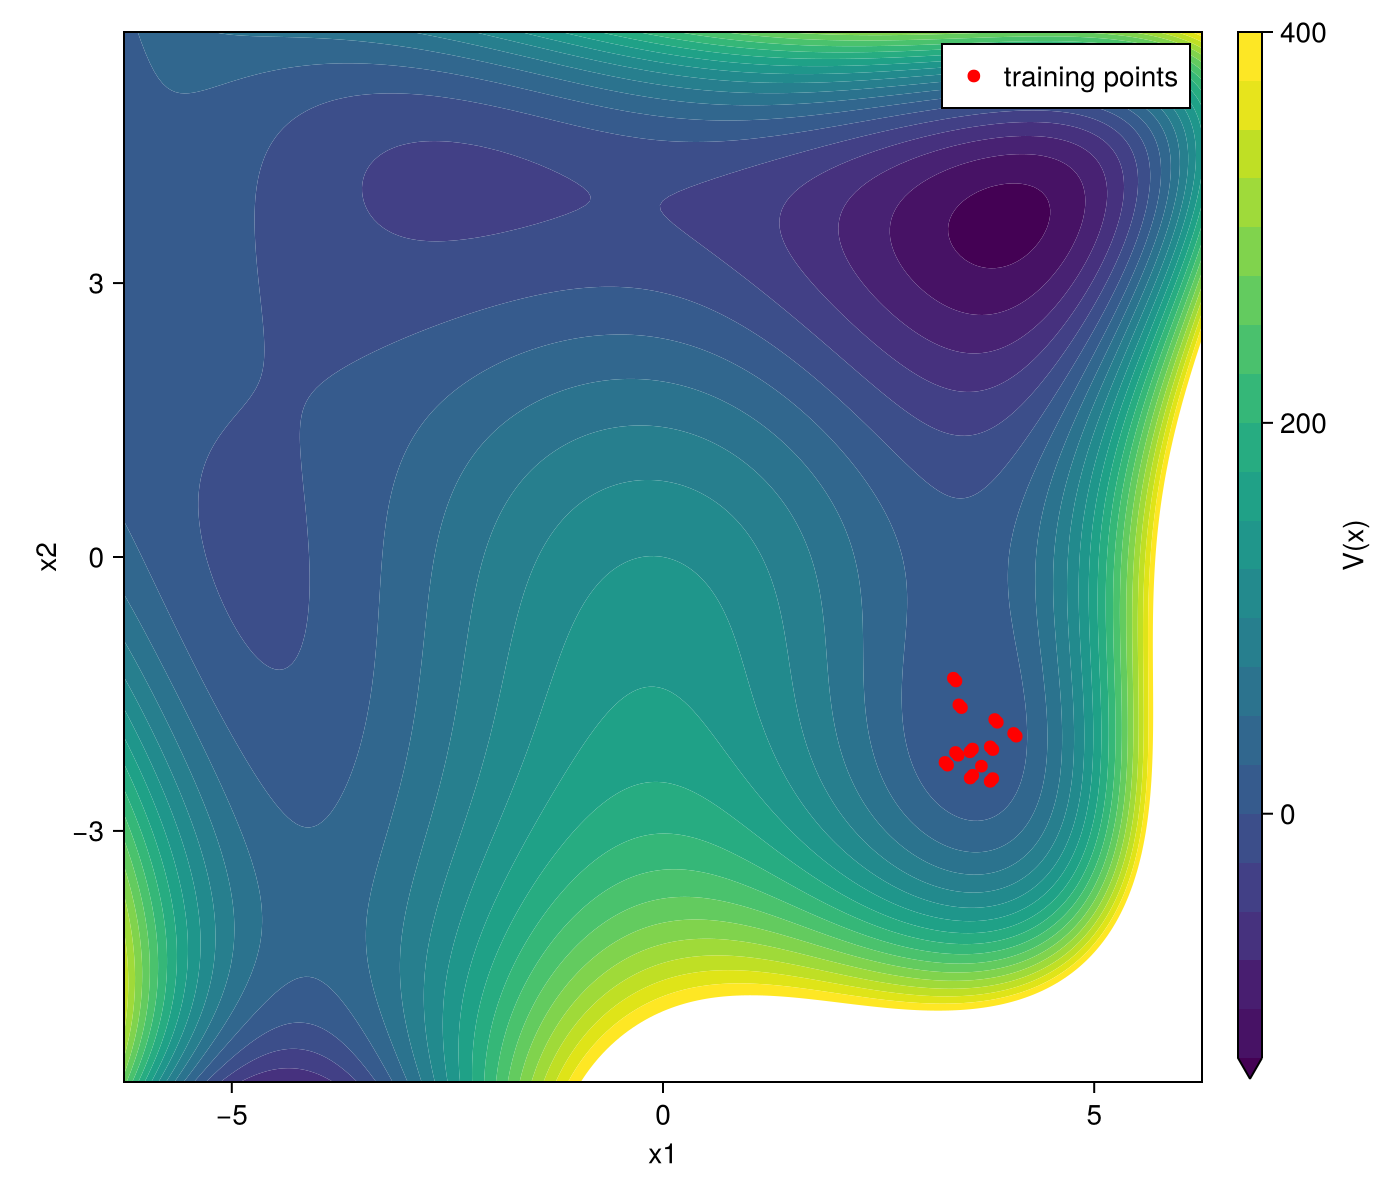

In [59]:
# plot
ctr_lvls0 = -125:25:400
f0, ax0 = plot_contours_2D(pce0, xcoord, ycoord; fill=true, lvls=ctr_lvls0)
coordmat = reduce(hcat, get_values(coords_train))'
scatter!(ax0, coordmat[:,1], coordmat[:,2], color=:red, label="training points")
axislegend(ax0)
f0

The initial fit of the PCE model is not very good, as a result of the training data being concentrated in a narrow region of the configurational space. We'd like to improve the fit of the PCE model through active learning.

## Two-stage active learning algorithm

The active learning algorithm in `active_learn!` implements an alternating-stage routine. In the first stage, we sample the configuration space by MD simulation. Here, we choose to use the `StochasticSVGD` simulator using the first 10 points of the training set as the active ensemble: 


In [60]:
ens0 = [System(
    atoms=[atoms_i],
    coords=[coords_i],
    boundary=boundary,
    general_inters=(pce0,),
    # k = 1.0u"kJ * K^-1 * mol^-1",
    loggers=(
        coords=CoordinateLogger(1; dims=2),
        ksd=StepComponentLogger(1; dims=2),
        # trigger=TriggerLogger(trigger2, 1),
        params=TrainingLogger(),
    )
) for (atoms_i, coords_i) in zip(atoms_train[1:10], coords_train[1:10])]

10-element Vector{System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, NamedTuple{(:coords, :ksd, :params), Tuple{GeneralObservableLogger{Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, typeof(Molly.coordinates_wrapper)}, StepComponentLogger{Vector{SVector{2, Quantit

In [61]:
# define kernel
rbf = RBF(Euclidean(2), β=0.2)

# define fixed system using initial PCE potential
sys_fix = [System(
    atoms=[atoms_i],
    coords=[coords_i],
    boundary=boundary,
    general_inters=(pce0,),
    # k = 1.0u"kJ * K^-1 * mol^-1",
) for (atoms_i, coords_i) in zip(atoms_train, coords_train)]

# define simulator
sim_svgd = StochasticSVGD(
            dt=0.002u"ps",
            kernel=rbf,
            kernel_bandwidth=median_kernel_bandwidth,
            sys_fix=sys_fix,
            temperature=temp,
            friction=1.0u"ps^-1")

StochasticSVGD{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, RBF, System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, Tuple{}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, K⁻¹, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², nothing}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothin

In the second stage, an "active learning trigger" stops simulation to retrain the PCE model. At this point, we evaluate the oracle (being the reference potential) on the current positions of particles in the ensemble, augment these data samples to the training set, and retrain the PCE model by linear least squares. We examine the performance of the active learning routine using two choices of trigger functions:

### 1. Time interval trigger

With the `TimeInterval` trigger, retraining of the PCE model is triggered at uniform intervals of steps during simulation.

In [62]:
trigger1 = TimeInterval(interval=1000)

TimeInterval(1000)

Define a struct `ActiveLearnRoutine` which contains all parameters required to trigger retraining during simulation. 

In [69]:
al1 = ActiveLearnRoutine(
    ref,
    pce0,
    sys_fix,
    GQint,
    trigger1,
    Dict("fd" => [], "rmse_e" => [], "rmse_f" => []),
    train_func = train_potential_e!,
)

ActiveLearnRoutine(Himmelblau{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(kJ nm⁻¹ mol⁻¹, kJ mol⁻¹), PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(5, 2, [29.650520811764505, 110.37314299818888, -57.81275366041635, 56.57322163758454, -10.706312723336678, -39.145685383982304, 9.11874068202661, -3.325647984306284, -0.1763337292648177, -12.19278479705572  …  -64.84460692203794, 41.91640164610561, -32.896115144881925, 69.53228881428252, 78.42481739933878, -105.78899379460489, 52.130940080682215, -14.072882525455128, 62.18561841427623, 18.59490251688096], Jacobi{0.5, 0.5}, Vector[Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₅(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, F

Now run the active learning loop:

In [70]:
ens = deepcopy(ens0)
al1, bwd = active_learn!(ens, sim_svgd, 12_000, al1)

train on step 1000
train on step 2000
train on step 3000
train on step 4000
train on step 5000
train on step 6000
train on step 7000
train on step 8000
train on step 9000
train on step 10000
train on step 11000
train on step 12000


(ActiveLearnRoutine(Himmelblau{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(kJ nm⁻¹ mol⁻¹, kJ mol⁻¹), PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(5, 2, [6.252065580572253e-11, 193.76240079322312, 6.001224389120574e-10, 2.4673817723439536e-9, -3.541088389691349e-9, 2.322061624644663e-9, 129.63867186789915, 119.7916666765205, -6.566611379319752e-9, 2.174122067526022e-9  …  -1.6584777883353344e-8, 110.20833334626617, -4.0869960598744545e-9, 9.166979141801805e-10, 184.84472655638112, -9.463541657515261, 156.01367186651504, 3.4523609296591264e-9, 138.81001984037977, 1.1225485420952867e-11], Jacobi{0.5, 0.5}, Vector[Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₅(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5

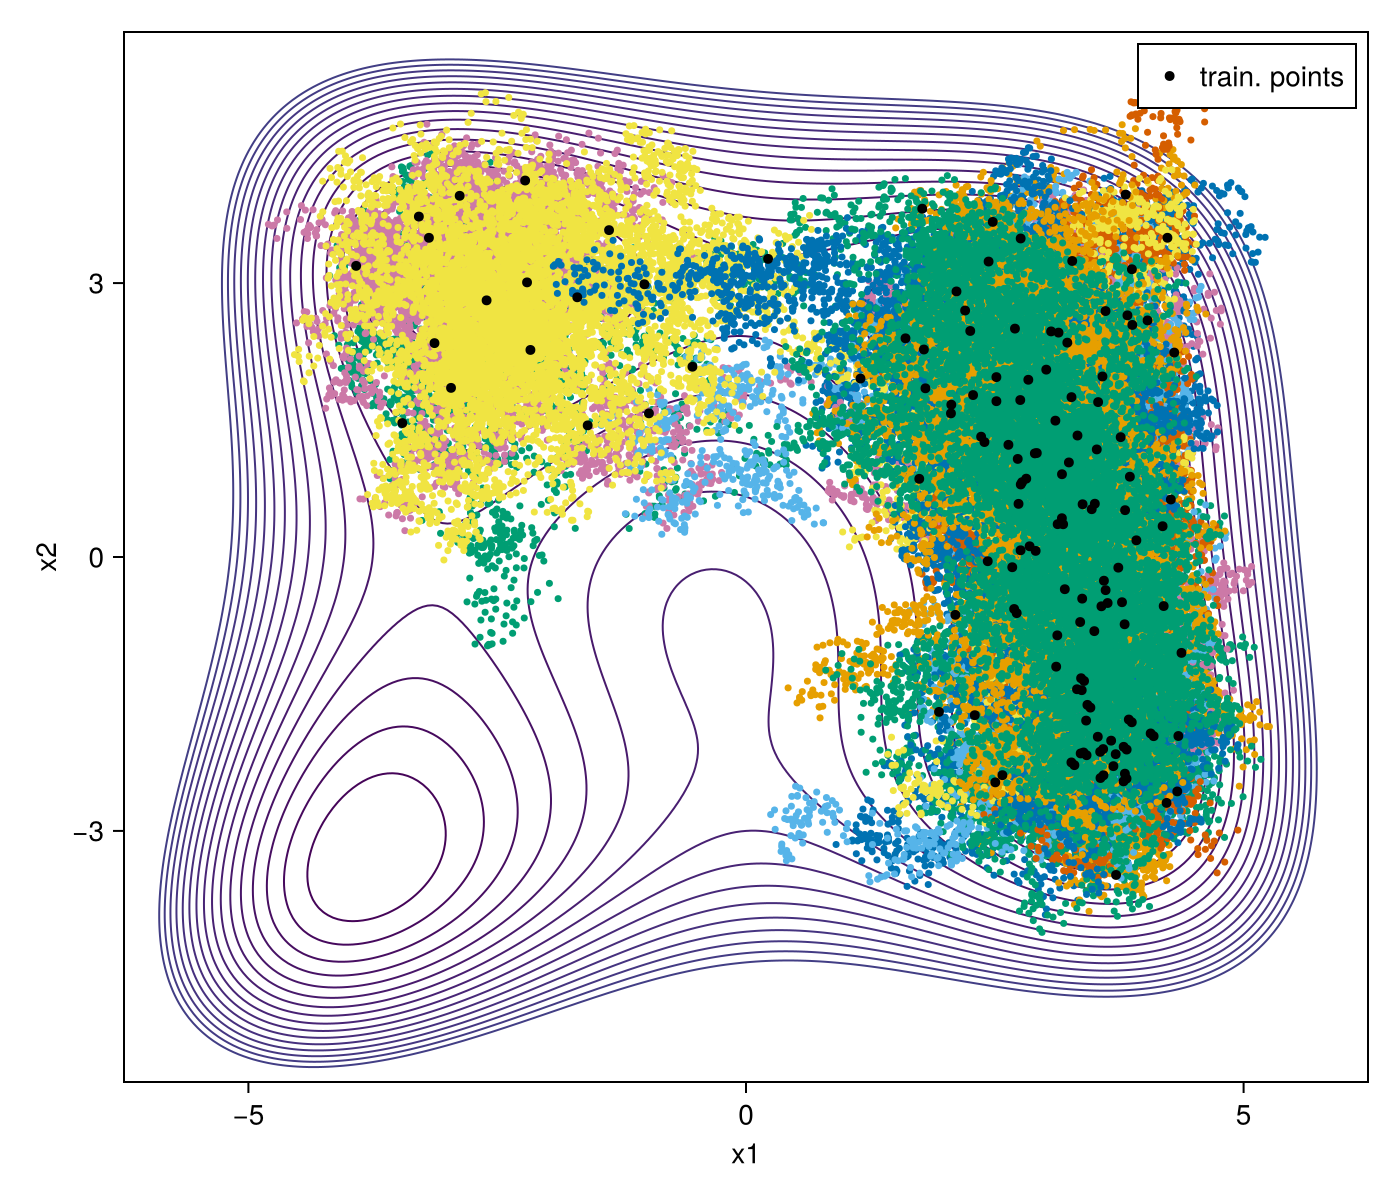

In [71]:
f = plot_md_trajectory(ens, al1.sys_train, ctr_grid, fill=false, lvls=ctr_lvls0, showpath=false)


### 2. MaxVol trigger

With the `MaxVol` trigger, retraining of the PCE model is triggered once one member of the active ensemble begins to "extrapolate" from the training data, as measured by a D-optimality based extrapolation metric.

In [114]:
function basis_eval(sys_train::Vector{<:System}, pce::PolynomialChaos)
    coords = get_coords(sys_train)
    xtrain = [ustrip.(coord[1]) for coord in coords]
    A = reduce(hcat, eval_basis.(xtrain, (pce,)))'
    return A
end

trigger2 = MaxVol(x -> basis_eval(x, pce0), thresh=1.22)

MaxVol(var"#190#191"(), Cairn.extrap_grade, 1.22)

In [115]:
al2 = ActiveLearnRoutine(
    ref,
    pce0,
    sys_fix,
    GQint,
    trigger2,
    Dict("fd" => [], "rmse_e" => [], "rmse_f" => []),
    train_func = train_potential_e!,
    burnin=100,
)

ActiveLearnRoutine(Himmelblau{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(kJ nm⁻¹ mol⁻¹, kJ mol⁻¹), PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(5, 2, [29.650520811764505, 110.37314299818888, -57.81275366041635, 56.57322163758454, -10.706312723336678, -39.145685383982304, 9.11874068202661, -3.325647984306284, -0.1763337292648177, -12.19278479705572  …  -64.84460692203794, 41.91640164610561, -32.896115144881925, 69.53228881428252, 78.42481739933878, -105.78899379460489, 52.130940080682215, -14.072882525455128, 62.18561841427623, 18.59490251688096], Jacobi{0.5, 0.5}, Vector[Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₅(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, F

In [116]:
ens = deepcopy(ens0)
al2, bwd = active_learn!(ens, sim_svgd, 12_000, al2)

train on step 742
train on step 2157
train on step 2296
train on step 4039
train on step 4568
train on step 5873
train on step 7106
train on step 7313
train on step 8392
train on step 8662
train on step 9982


(ActiveLearnRoutine(Himmelblau{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(kJ nm⁻¹ mol⁻¹, kJ mol⁻¹), PolynomialChaos{Type{Jacobi{0.5, 0.5}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(5, 2, [-4.561470088071806e-11, 193.7624007932635, 9.90681549804468e-10, 4.100864793193959e-9, -5.988851523267421e-9, 4.571571987629983e-9, 129.6386718634241, 119.79166668859901, -1.4852954077367426e-8, 6.269021994813525e-9  …  -2.9381274254139767e-8, 110.20833335991367, -1.2350547351751766e-8, 3.4546830291466465e-9, 184.84472655282642, -9.463541646444716, 156.01367185829045, 9.322985881935847e-9, 138.8100198387843, 3.110728698053723e-10], Jacobi{0.5, 0.5}, Vector[Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₅(x)), typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₀(x))], Jacobi{0.5, 0.5, Float64, :x}[typename(Jacobi){0.5,0.5}(1.0⋅Jᵅᵝ₄(x)), typename(Jacobi){0.5,0.5

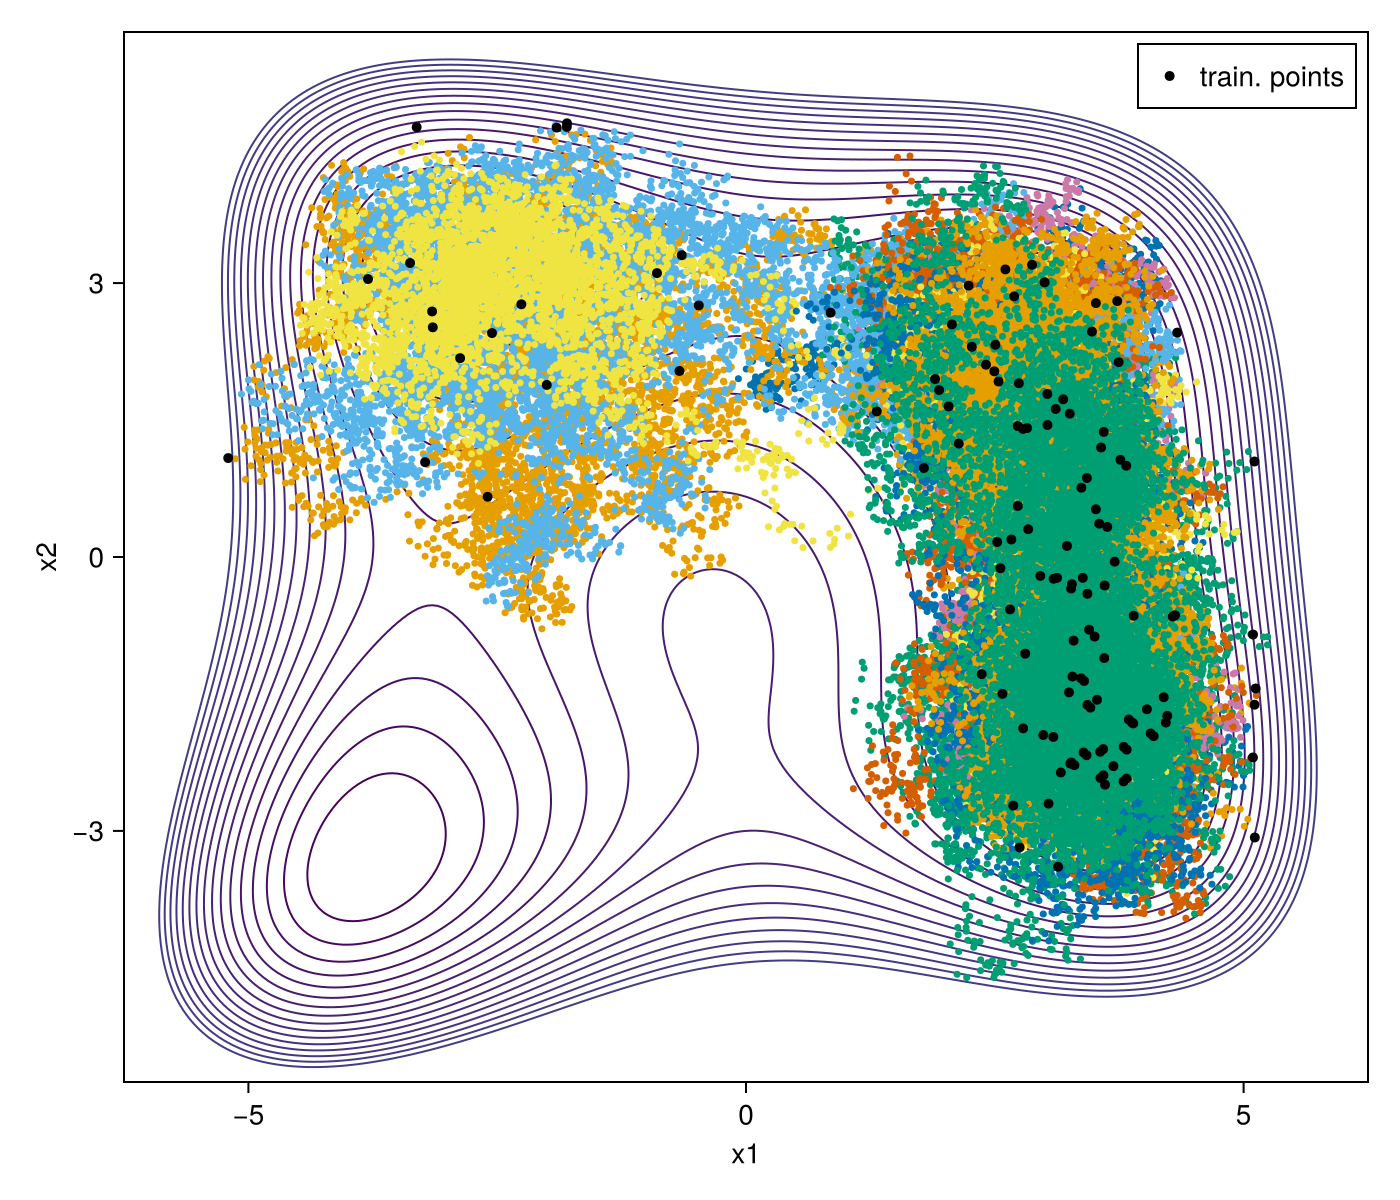

In [117]:
f = plot_md_trajectory(ens, al2.sys_train, ctr_grid, fill=false, lvls=ctr_lvls0, showpath=false)


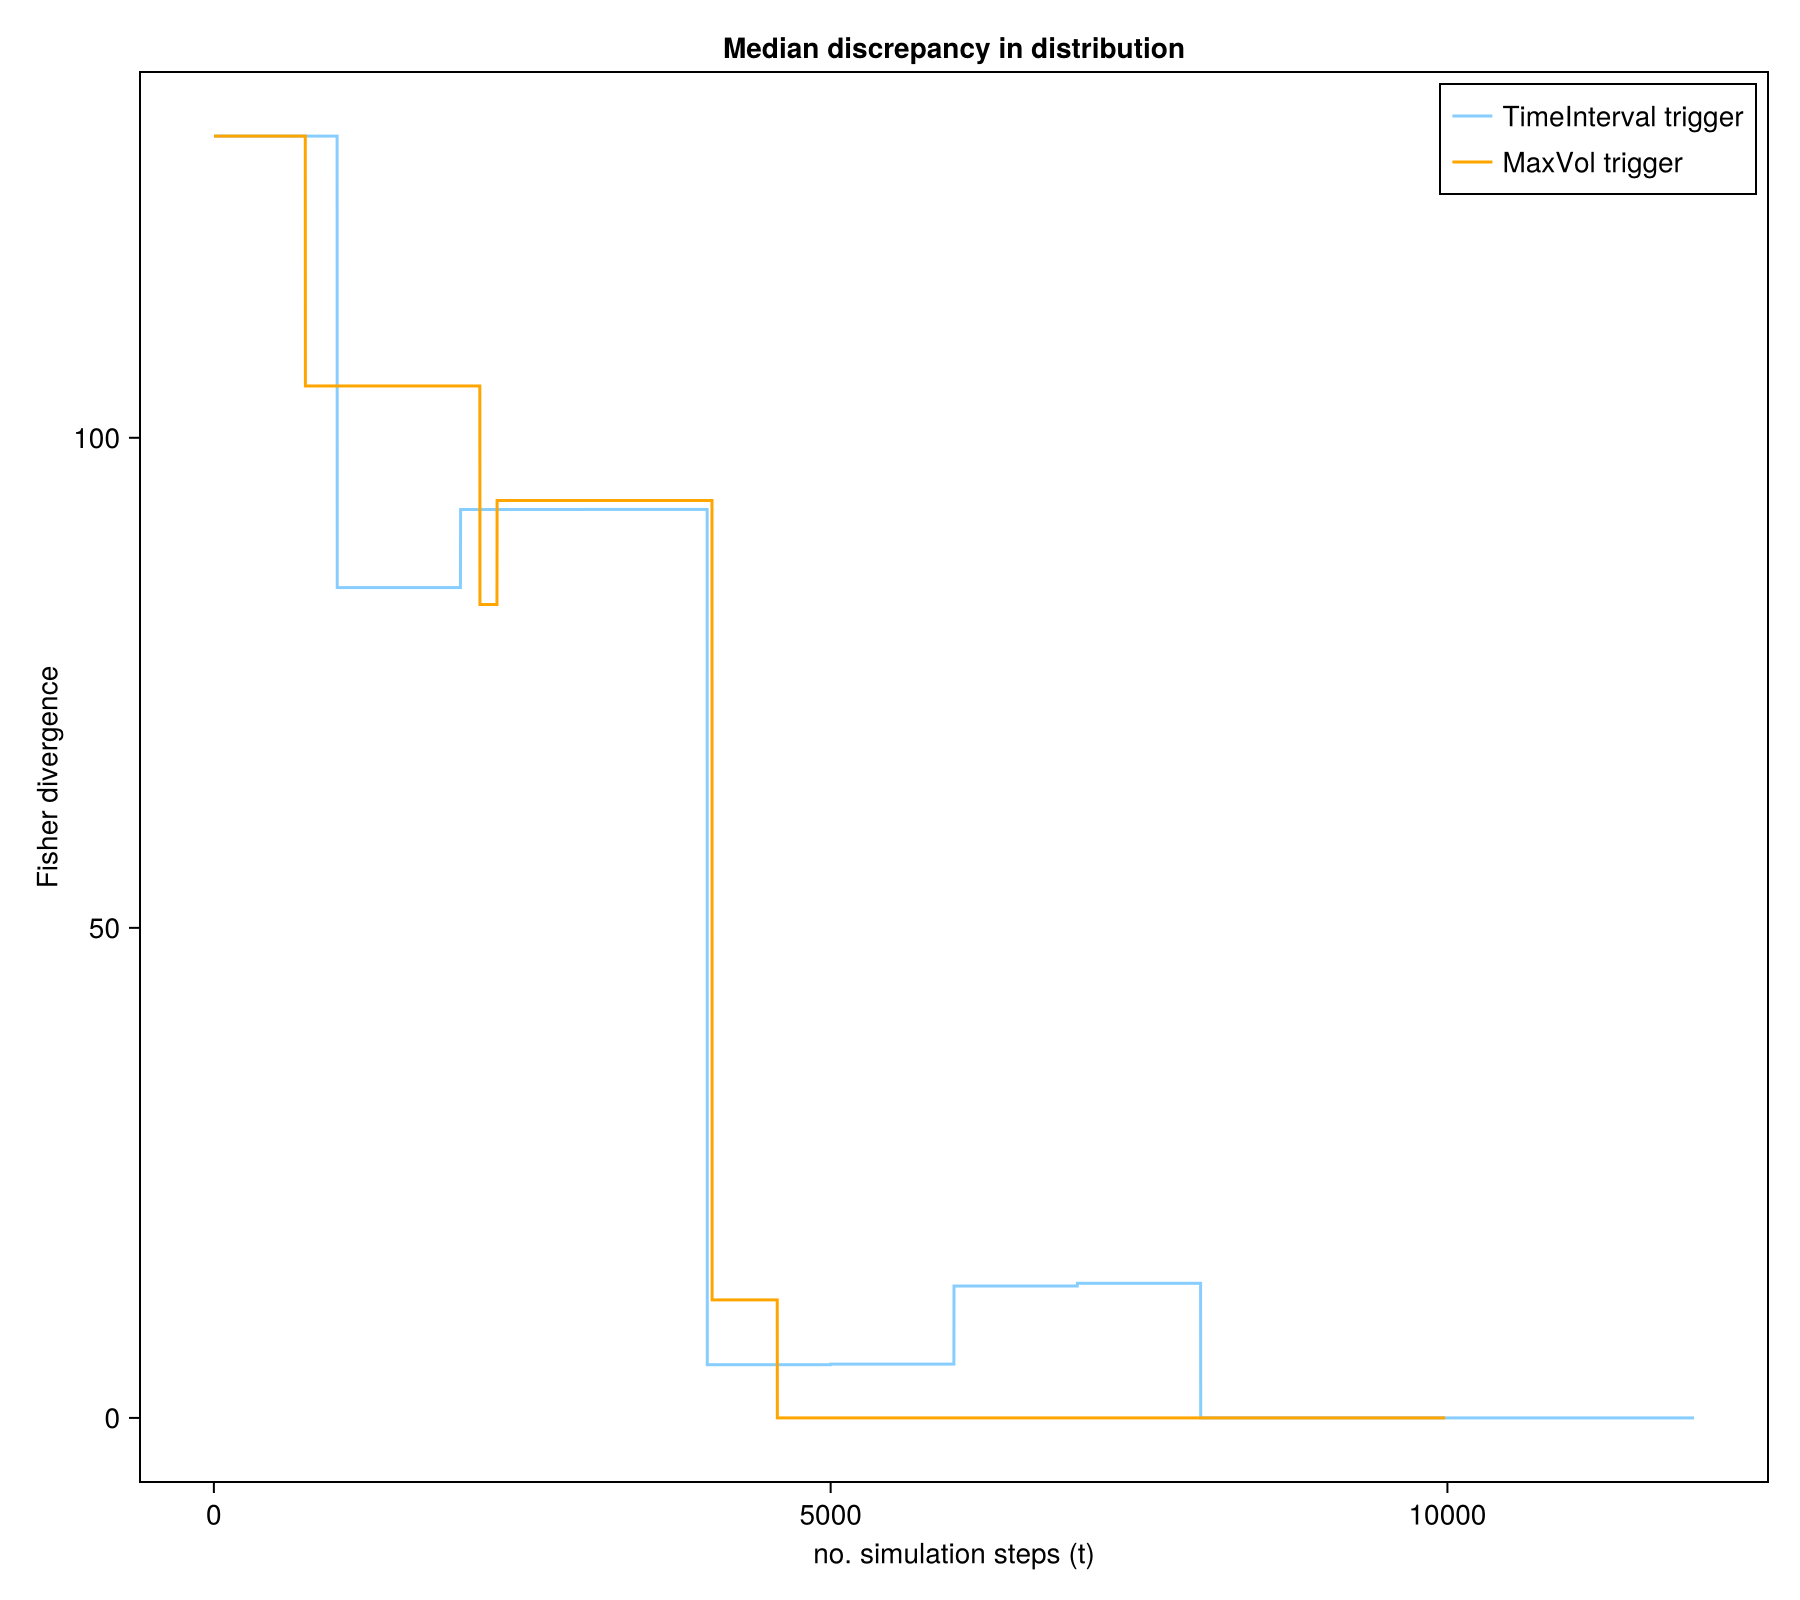

In [136]:
f = Figure(size = (900, 800))
ax1 = Axis(f[1,1],
    xlabel="no. simulation steps (t)",
    ylabel="Fisher divergence", 
    title="Median discrepancy in distribution",
    xgridvisible=false,
    ygridvisible=false,
    # yscale=log10
    )

err = al1.error_hist["rmse_e"]
alsteps = al1.train_steps
err_vec1 = reduce(vcat, [err[i].*ones(alsteps[i+1]-alsteps[i]) for i = 1:length(err)-1])
lines!(ax1, 1:length(err_vec1), err_vec1, color=:skyblue1, label="TimeInterval trigger")
# [vlines!(ax1, alsteps[i], color=(:skyblue1,0.5), linestyle=:dash) for i = 1:length(alsteps)]

err = al2.error_hist["rmse_e"]
alsteps = al2.train_steps
err_vec2 = reduce(vcat, [err[i].*ones(alsteps[i+1]-alsteps[i]) for i = 1:length(err)-1])
lines!(ax1, 1:length(err_vec2), err_vec2, color=:orange, label="MaxVol trigger")
# [vlines!(ax1, alsteps[i], color=(:orange,0.5), linestyle=:dash) for i = 1:length(alsteps)]

axislegend(ax1)
f